# **Installing & Calling Libraries**

In [2]:
!pip install isbnlib
!pip install newspaper3k
!pip install goodreads_api_client
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.1 MB/s 


In [3]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# **Uploading & Reading Dataset From Local Drive**

In [4]:
from google.colab import files
data = files.upload()

Saving books.csv to books.csv


In [5]:
df = pd.read_csv('books.csv', error_bad_lines = False)

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


# **EDA**

In [6]:
df.index = df['bookID']
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 13714 rows and 10 columns


In [7]:
df.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)

In [8]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,0439785960,9780439785969,eng,652,1944099,26249
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,1996446,27613
3,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,0439554934,9780439554930,eng,320,5629932,70390
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,043965548X,9780439655484,eng,435,2149872,33964


In [9]:
df.tail()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
47699,47699,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,0061186422,9780061186424,eng,260,11317,1060
47700,47700,Black Orchid,Neil Gaiman-Dave McKean,3.72,0930289552,9780930289553,eng,160,8710,361
47701,47701,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,0061238961,9780061238963,en-US,239,14334,1485
47708,47708,The Faeries' Oracle,Brian Froud-Jessica Macbeth,4.43,0743201116,9780743201117,eng,224,1550,38
47709,47709,The World of The Dark Crystal,Brian Froud,4.29,1862056242,9781862056244,eng,132,3572,33


In [10]:
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
# num_pages             int64
ratings_count           int64
text_reviews_count      int64
dtype: object

**books with most occurances in the list**

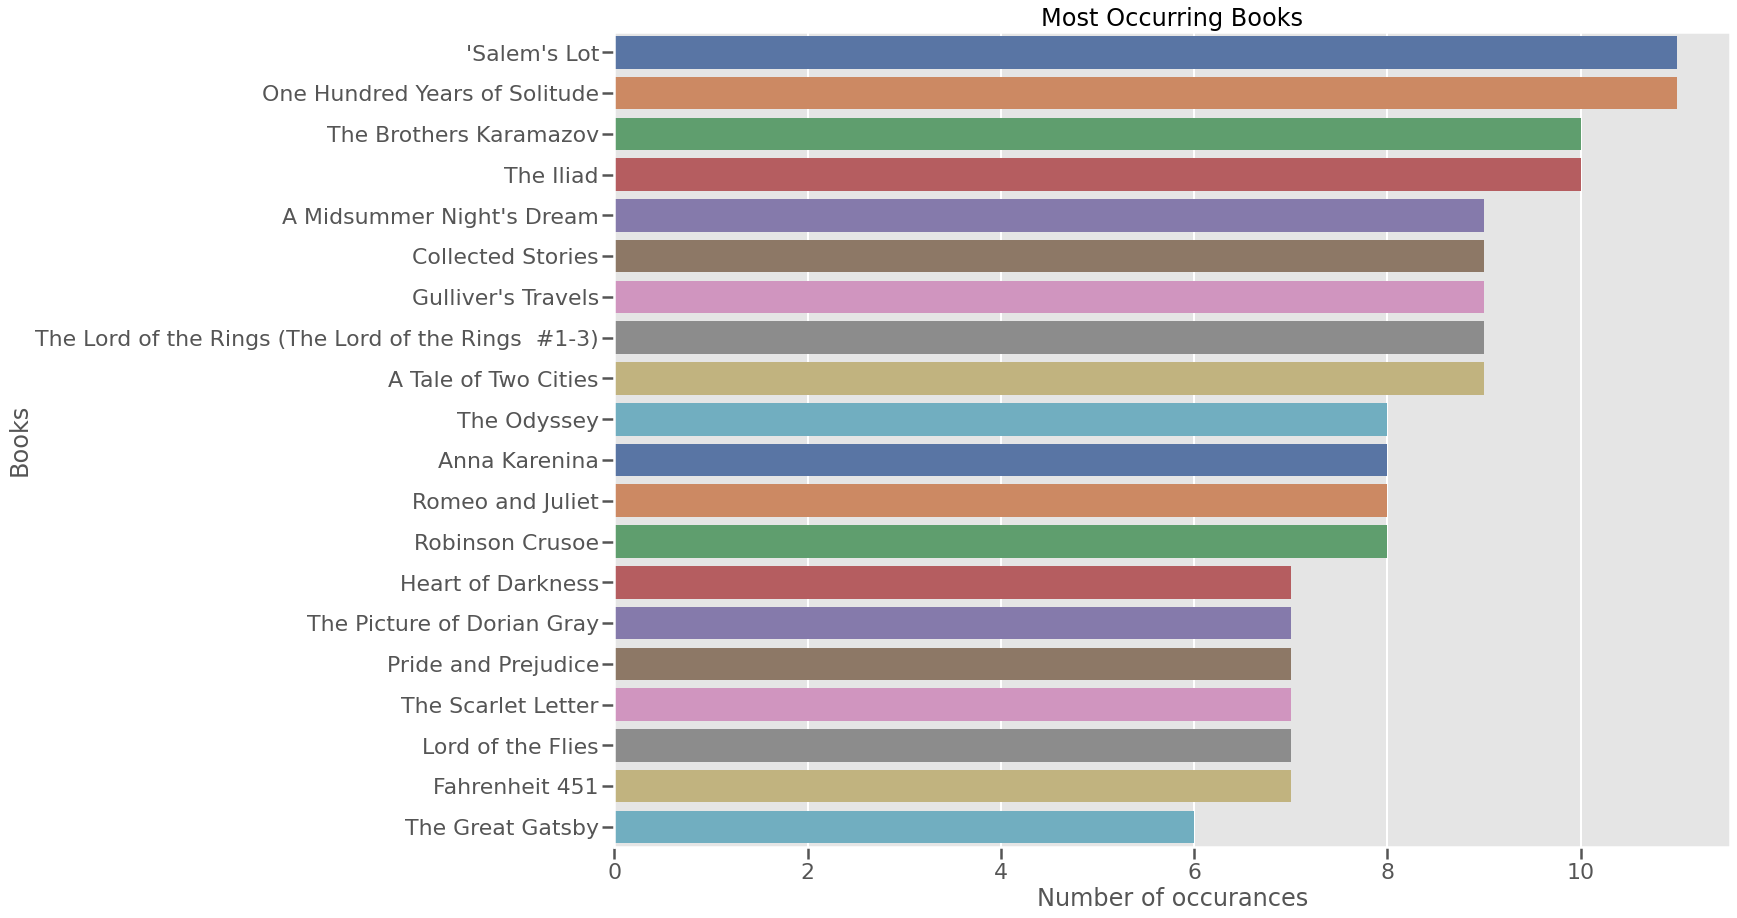

In [11]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
books = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

**distribution of books for all languages**

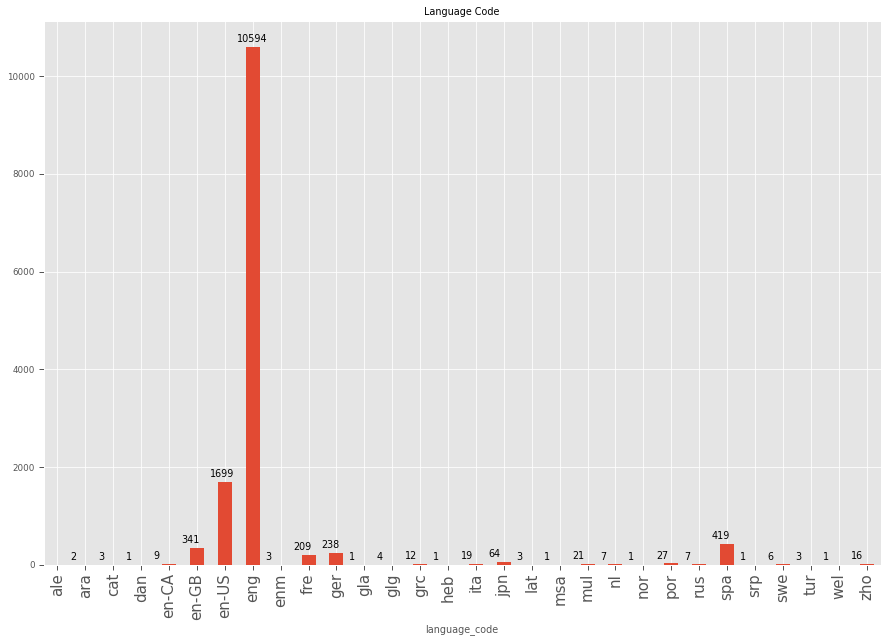

In [12]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

**top 10 most rated books**

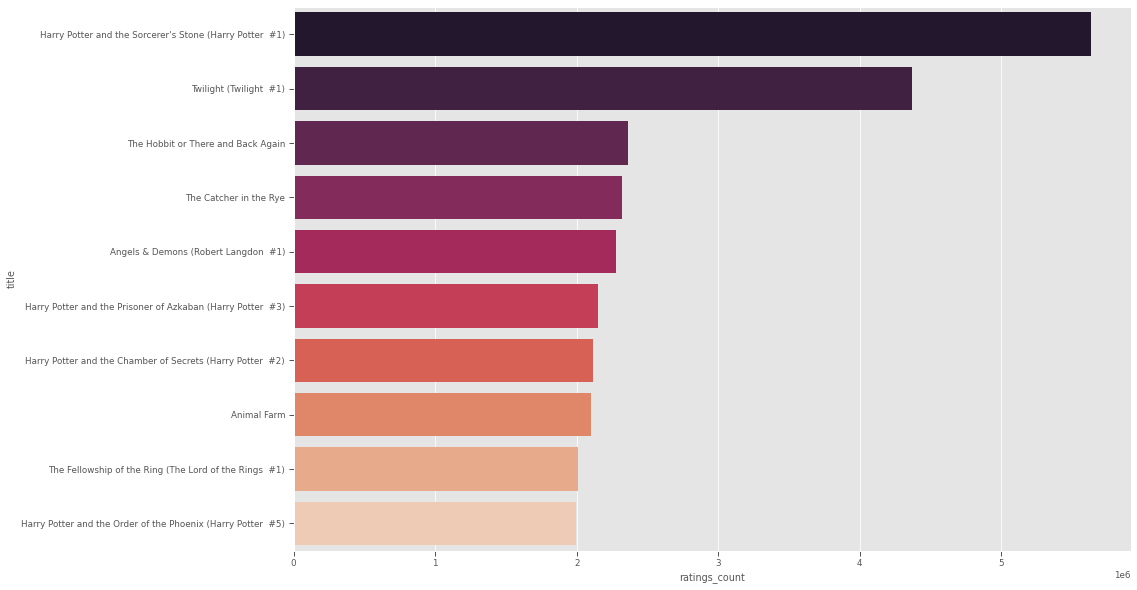

In [13]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='rocket')

**the authors with most books**

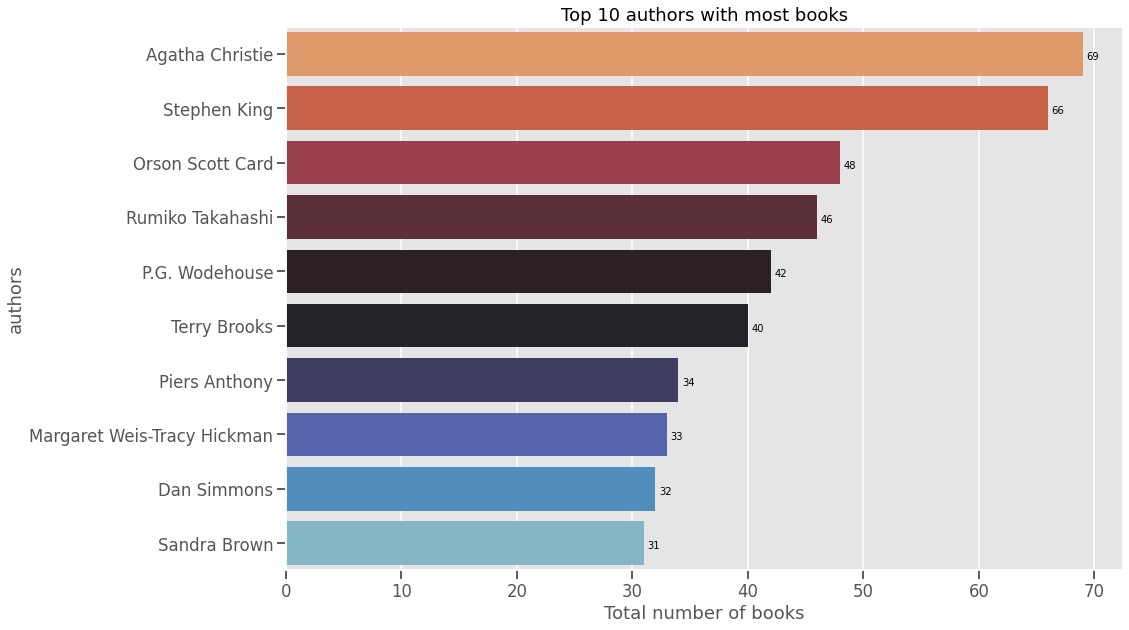

In [14]:
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

**top 10 highly rated authors**

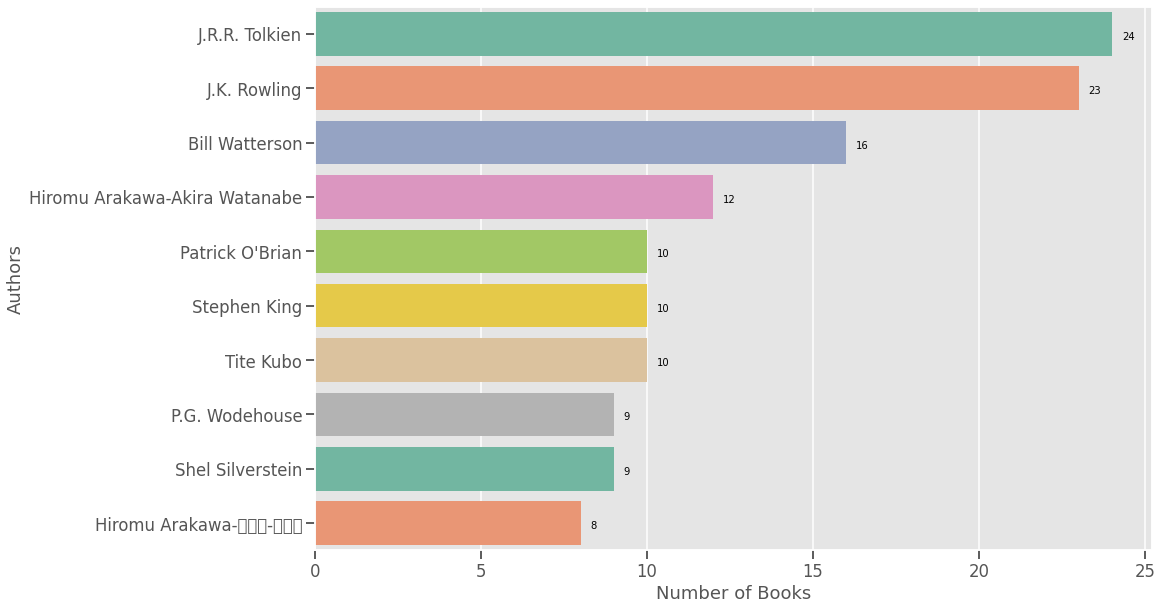

In [15]:
high_rated_author = df[df['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='Set2')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

**rating distribution for the books**

In [16]:
def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

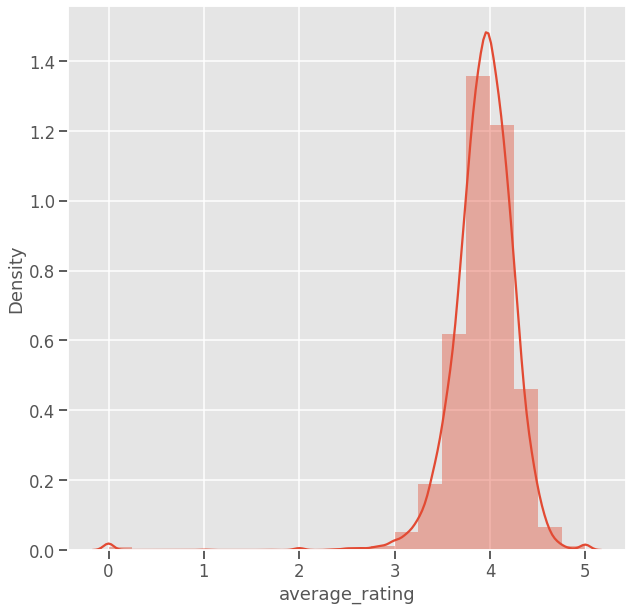

In [17]:
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)

13714


b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


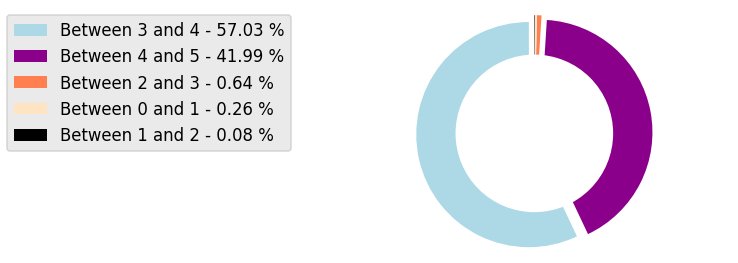

In [18]:
df1 = pd.read_csv('books.csv', error_bad_lines = False)
df1.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)
df1['Ratings_Dist'] = segregation(df1)
ratings_pie = df1['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)

**relationship between ratings and review counts**

<Figure size 1080x720 with 0 Axes>

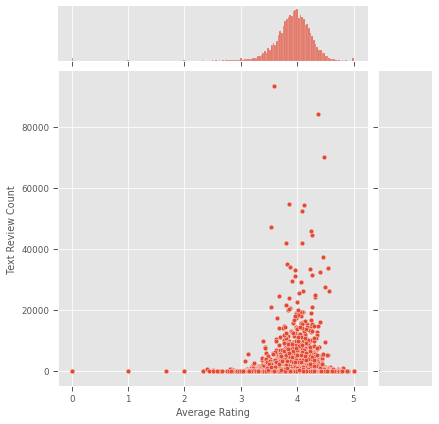

In [19]:
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

In [20]:
trial = df[~(df['text_reviews_count']>5000)]

<Figure size 1080x720 with 0 Axes>

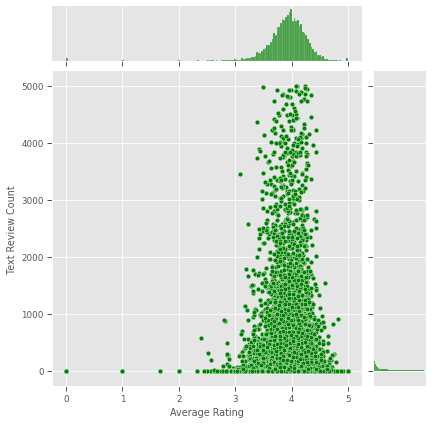

In [21]:
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

**relationship between number of pages and ratings**

<Figure size 1080x720 with 0 Axes>

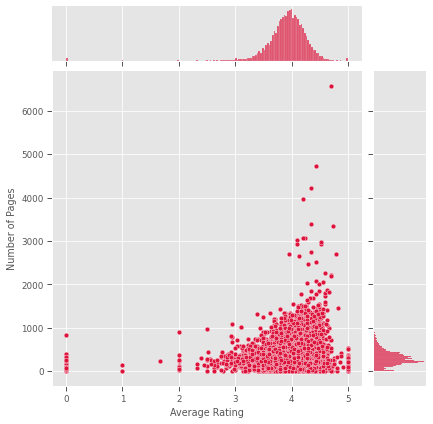

In [22]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="# num_pages", data = df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")

In [23]:
trial = df[~(df['# num_pages']>1000)]

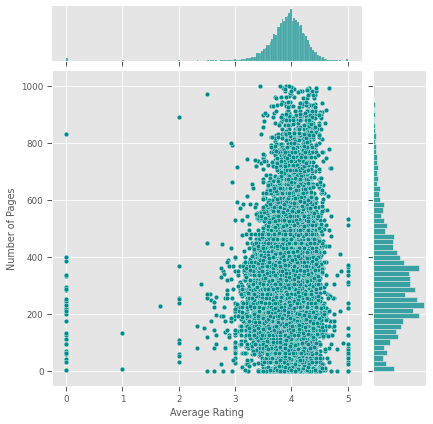

In [24]:
ax = sns.jointplot(x="average_rating", y="# num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")

**relationship between ratings and ratings count**

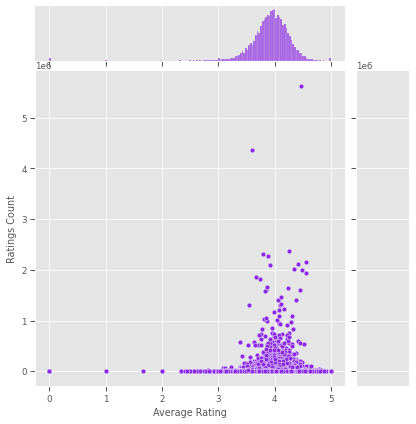

In [25]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")

In [26]:
trial = df[~(df.ratings_count>2000000)]

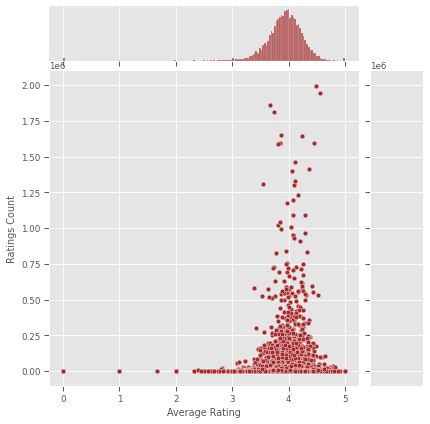

In [27]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'brown')
ax.set_axis_labels("Average Rating", "Ratings Count")

**books with the highest reviews**

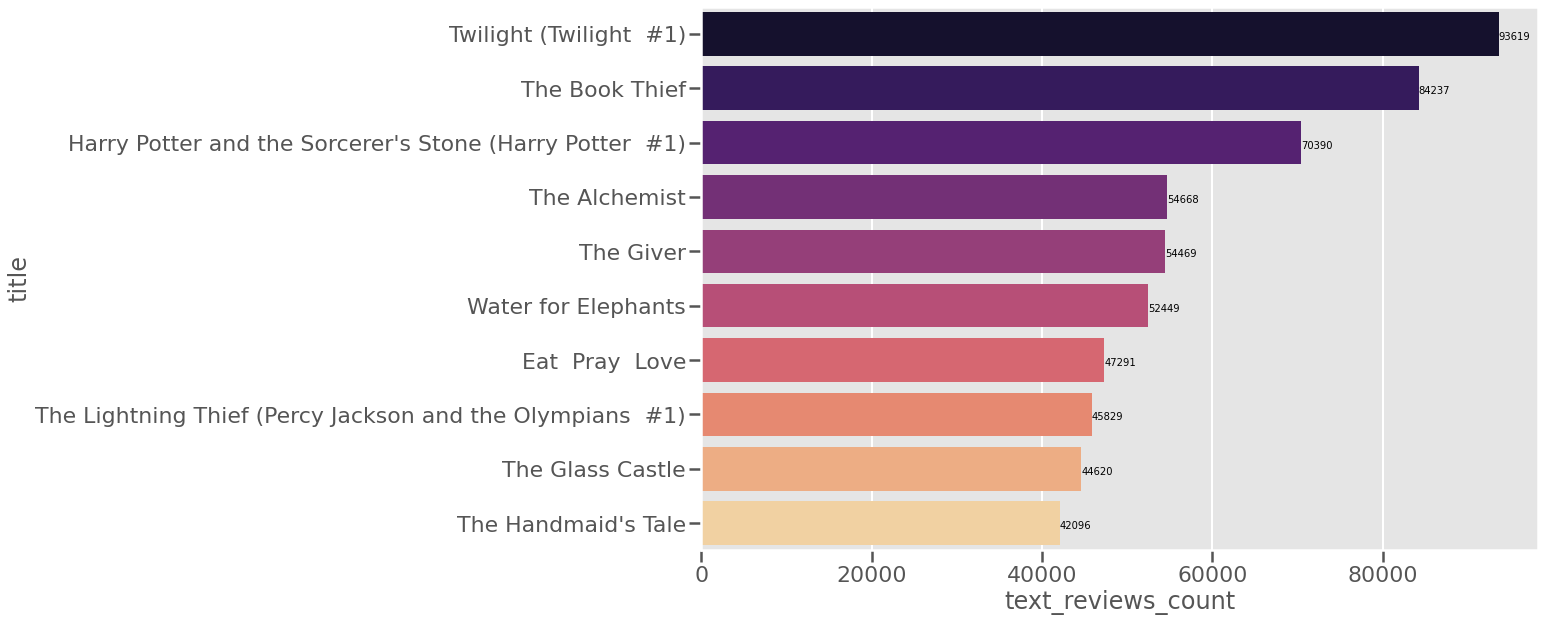

In [28]:
most_text = df.sort_values('text_reviews_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.set_context('poster')
ax = sns.barplot(most_text['text_reviews_count'], most_text.index, palette='magma')
for i in ax.patches:
    ax.text(i.get_width()+2, i.get_y()+0.5,str(round(i.get_width())), fontsize=10,color='black')
plt.show()

# **Data Pre-Processing**

**Basic inspections & Removing Useless Columns**

In [29]:
columns_to_drop = ['bookID', 'isbn', 'isbn13']
df.drop(columns=columns_to_drop, inplace=True)
df

,title,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,eng,652,1944099,26249
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,eng,870,1996446,27613
3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,eng,320,5629932,70390
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,eng,352,6267,272
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,eng,435,2149872,33964
...,...,...,...,...,...,...,...
47699,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,eng,260,11317,1060
47700,Black Orchid,Neil Gaiman-Dave McKean,3.72,eng,160,8710,361
47701,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,en-US,239,14334,1485


**Nulls & Duplicates**

In [30]:
df.isnull().sum()

title                 0
authors               0
average_rating        0
language_code         0
# num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

In [31]:
df[df.duplicated()]

,title,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,


**Removing Outliers**

In [32]:
from collections import Counter

In [33]:
def detect_outliers(data_frame=df, n=2):
  
    
    numeric_columns = data_frame.select_dtypes(include=[np.number])
    outlires_indicies = []
    
    for column in numeric_columns:
        
        #  first quartile - 25 %
        Q1 = np.nanpercentile(data_frame[column], 25)
        
        #  second quartile - 75%
        Q2 = np.nanpercentile(data_frame[column], 75)
        
        #  calculating interquartile range
        IQR = Q2 - Q1
        
        # setting the bounds
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q2 + (1.5 * IQR)
        
        # indexes of the outliers
        outliers = data_frame[(data_frame[column] < lower_bound) | (data_frame[column] > upper_bound)].index
        
        #  extending the indicies to the list
        outlires_indicies.extend(outliers)
    
    #  this frequency table is useful to see occurences of outliers in rows
    freq_table = Counter(outlires_indicies)
    
    #  showing only indicies where theres more than n outliers
    return [index for index, occurences in freq_table.items() if occurences > n]

In [34]:
outliers = detect_outliers()
df.drop(index=outliers, inplace=True)
f'outliers droped - {len(outliers)}'

'outliers droped - 104'

In [35]:
df.shape

(13610, 7)

**Data Standardization**

In [36]:
from sklearn.preprocessing import scale
cols = ['ratings_count', 'text_reviews_count']
df[cols] = scale(df[cols])
df

,title,authors,average_rating,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,eng,652,17.502416,10.478494
3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,eng,320,50.974817,28.446467
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,eng,352,-0.095747,-0.095666
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,eng,435,19.371116,13.618951
9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.69,en-US,152,-0.152497,-0.205979
...,...,...,...,...,...,...,...
47699,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,eng,260,-0.049886,0.225096
47700,Black Orchid,Neil Gaiman-Dave McKean,3.72,eng,160,-0.073561,-0.059438
47701,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,en-US,239,-0.022488,0.398096


# **Train & Test Split**

In [67]:
df_train,df_test=train_test_split(df,test_size=0.2)

In [68]:
df_train.shape

(10888, 7)

In [69]:
df_test.shape

(2722, 7)

**Train & Test Configuration for Clustering**

In [70]:
trial_train = df_train[['average_rating', 'ratings_count']]
data_train = np.asarray([np.asarray(trial_train['average_rating']), np.asarray(trial_train['ratings_count'])]).T

In [71]:
trial_test = df_test[['average_rating', 'ratings_count']]
data_test = np.asarray([np.asarray(trial_test['average_rating']), np.asarray(trial_test['ratings_count'])]).T

# **Clustering Modeling**

**K-Means.Train**

Identifying Number of Clusters

Text(0.5, 1.0, 'Elbow Curve')

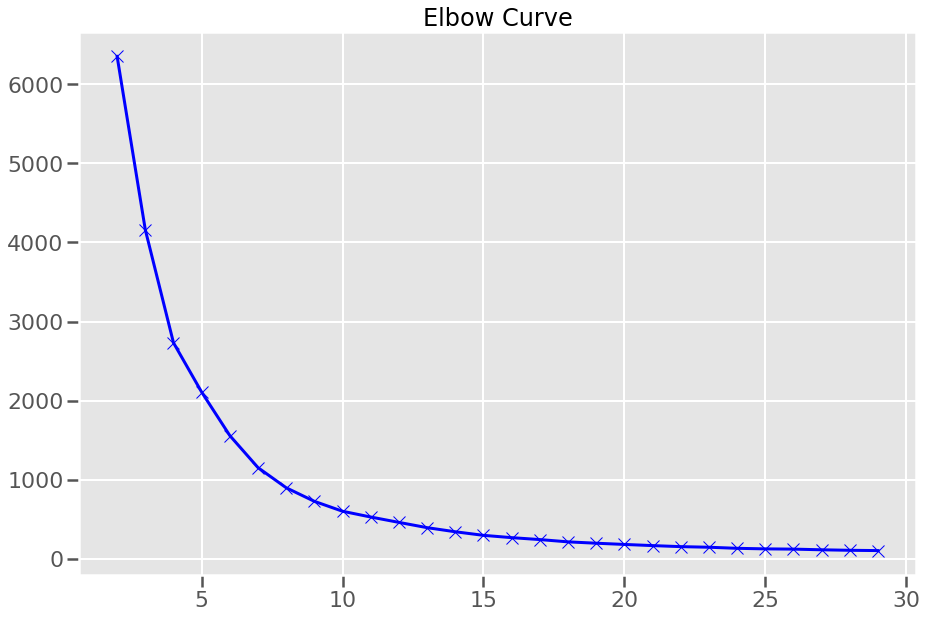

In [73]:
X = data_train
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

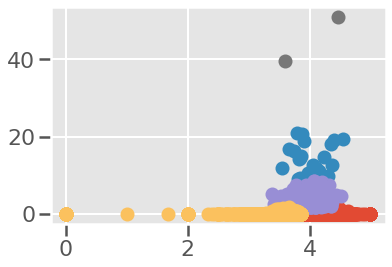

In [74]:
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
from matplotlib import pyplot
X = data_train
# define the model
model = KMeans(n_clusters=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**K-Means.Test**

Text(0.5, 1.0, 'Elbow Curve')

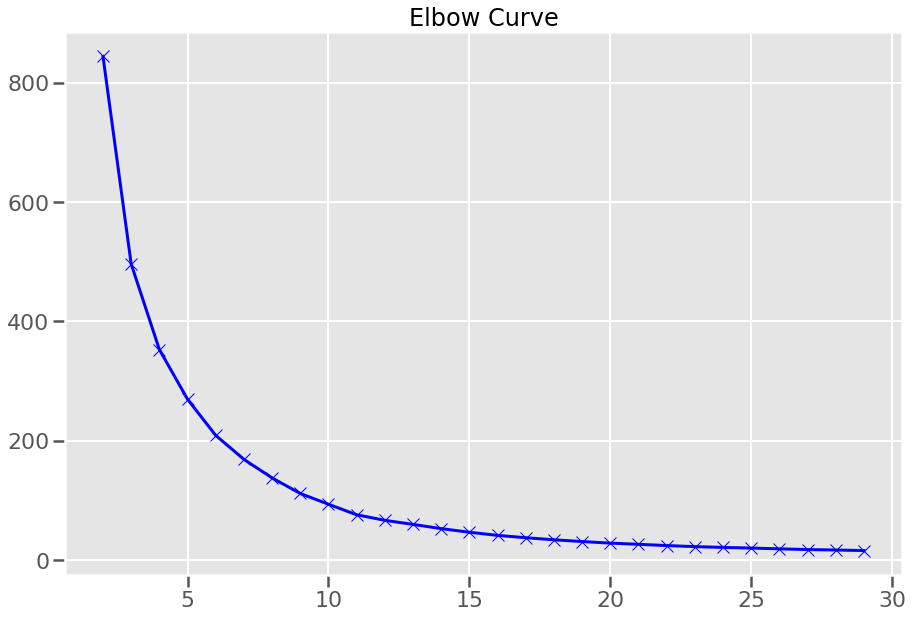

In [75]:
X_test = data_test
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X_test)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

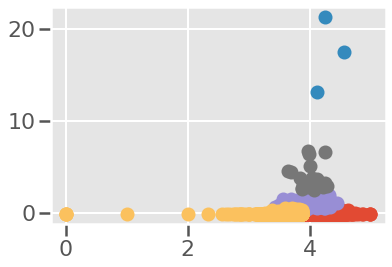

In [76]:
X = data_test
# define the model
model = KMeans(n_clusters=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**Agglomerative.Train**

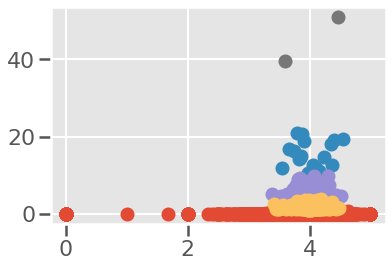

In [77]:
from sklearn.cluster import AgglomerativeClustering
X = data_train
# define the model
model = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**Agglomerative.Test**

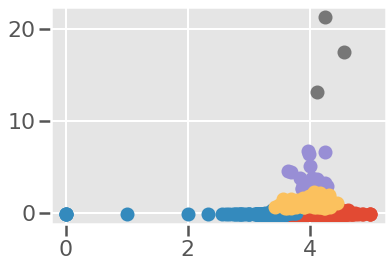

In [78]:
X = data_test
# define the model
model = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**BIRCH.Train**

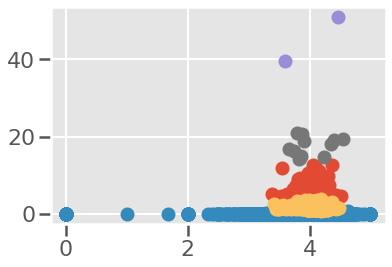

In [79]:
from sklearn.cluster import Birch
X = data_train
# define the model
model = Birch(threshold=0.01, n_clusters=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**BIRCH.Test**

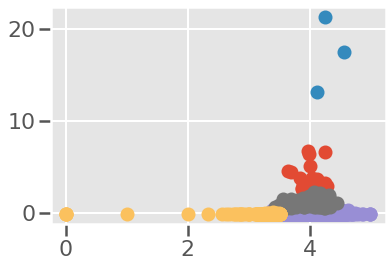

In [81]:
X = data_test
# define the model
model = Birch(threshold=0.01, n_clusters=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**Gaussian Mixture.Train**

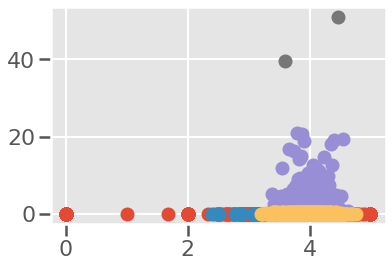

In [82]:
# gaussian mixture clustering
from sklearn.mixture import GaussianMixture
X = data_train
# define the model
model = GaussianMixture(n_components=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**Gaussian Mixture.Test**

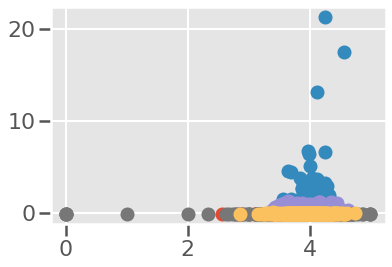

In [83]:
X = data_test
# define the model
model = GaussianMixture(n_components=5)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# **Recommendation Engine**

In [84]:
df['Ratings_Dist'] = segregation(df)


13610


In [85]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)


In [86]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.56,17.502416
3,0,0,0,0,1,4.47,50.974817
4,0,0,0,0,1,4.41,-0.095747
5,0,0,0,0,1,4.55,19.371116
9,0,0,0,1,0,3.69,-0.152497


In [87]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [88]:
np.round(books_features, 2)

array([[0.  , 0.  , 0.  , ..., 1.  , 0.91, 0.35],
       [0.  , 0.  , 0.  , ..., 1.  , 0.89, 1.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.88, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.71, 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.89, 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.86, 0.  ]])

In [89]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

In [90]:
def get_index_from_name(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

**Examples for Engine**

In [91]:
print_similar_books("The Catcher in the Rye")

Bloody River Blues (John Pellam  #2)
Book of Dreams
Thumbsucker
Americana
Don't Look Down


In [92]:
print_similar_books("The Hobbit or There and Back Again")

All the Sad Young Men (Works of F. Scott Fitzgerald)
The Laughing Jesus: Religious Lies and Gnostic Wisdom
Manna from Heaven
A Short History of World War I
The Parrot's Lament  and Other True Tales of Animal Intrigue  Intelligence  and Ingenuity


In [93]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 1
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 12564
Harry Potter and the Goblet of Fire (Harry Potter  #4) 12567


In [94]:
print_similar_books(id = 1) #ID for the Book 5

The Hobbit or There and Back Again
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Half-Blood Prince (Harry Potter  #6)
